In [210]:
import sys
!git clone https://github.com/diman199888/quantitative-finance.git
sys.path.append("/content/quantitative-finance/crypto-arbitrage-model/")

import crypto_arb_utils as cc

import importlib
importlib.reload(cc)

from sqlalchemy import create_engine
import sqlite3
import psycopg2

import pandas as pd
import numpy as np
import polars as pl

import time
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import logging
from tqdm import tqdm

import statsmodels.api as sm

pd.set_option('display.max_columns',  None)
#pd.set_option('display.max_rows', 250)

import sklearn
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, zero_one_loss, make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

!pip install optuna
import optuna

import joblib

fatal: destination path 'quantitative-finance' already exists and is not an empty directory.


In [291]:
#setup the logging module
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Preprocess collected data

In [ ]:
database_path_in_drive = '/content/drive/My Drive/Databases/crypto.db'
engine = create_engine(f"sqlite:///{database_path_in_drive}")  #the data from postgresql was transfered to sqlite due to Colab's pecularities
df = cc.download_data(engine)
df

2025-06-12 16:15:28,337 - INFO - Connecting to database…
2025-06-12 16:17:45,884 - INFO - Data loaded
2025-06-12 16:18:53,236 - INFO - Loaded rows:26,390,595
Time elapsed:204.90 s


exchange,ts,side,level1_price,level1_size,level2_price,level2_size,level3_price,level3_size
str,i64,str,f64,f64,f64,f64,f64,f64
"""Bybit""",1744811324776,"""bid""",74.06,68.30026,74.05,93.52903,74.04,156.80797
"""Bybit""",1744811324776,"""ask""",74.08,16.93638,74.09,48.66282,74.1,47.20968
"""Bybit""",1744811324896,"""bid""",74.06,68.30026,74.05,100.28442,74.04,156.80797
"""Bybit""",1744811324976,"""bid""",74.06,71.67544,74.05,100.28442,74.04,156.80797
"""Bybit""",1744811325196,"""bid""",74.07,8.1,74.06,71.67544,74.05,100.28442
…,…,…,…,…,…,…,…,…
"""Bybit""",1746643832136,"""ask""",87.94,0.17196,87.95,85.63987,87.96,94.85292
"""HTX""",1746643832109,"""ask""",87.93,21.8137,87.94,3.24,87.95,20.14
"""Bybit""",1746643832176,"""ask""",87.94,0.17196,87.95,89.67909,87.96,94.85292


In [ ]:
exchange1 = "HTX"
exchange2 = "Bybit"

In [ ]:
df_exchange1 = cc.get_orderbook_snapshot(df, exchange1)
df_exchange2 = cc.get_orderbook_snapshot(df, exchange2)

2025-06-12 16:18:57,441 - INFO - DataFrame for HTX processed. Number of rows:
9,737,563
2025-06-12 16:19:03,450 - INFO - DataFrame for Bybit processed. Number of rows:
12,108,887


In [ ]:
df_merged = cc.merge_data(df_exchange1, exchange1, df_exchange2, exchange2)
df_merged

2025-06-12 16:19:19,696 - INFO - DataFrames for HTX and Bybit processed. 
Number of rows: 21,637,878


ts,HTX_level1_price_bid,HTX_level1_size_bid,HTX_level2_price_bid,HTX_level2_size_bid,HTX_level3_price_bid,HTX_level3_size_bid,HTX_level1_price_ask,HTX_level1_size_ask,HTX_level2_price_ask,HTX_level2_size_ask,HTX_level3_price_ask,HTX_level3_size_ask,HTX_delta_ts,Bybit_level1_price_bid,Bybit_level1_size_bid,Bybit_level2_price_bid,Bybit_level2_size_bid,Bybit_level3_price_bid,Bybit_level3_size_bid,Bybit_level1_price_ask,Bybit_level1_size_ask,Bybit_level2_price_ask,Bybit_level2_size_ask,Bybit_level3_price_ask,Bybit_level3_size_ask,Bybit_delta_ts,timedelta
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
1744811325304,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,28,74.07,13.48915,74.06,93.78829,74.05,145.46272,74.08,0.37586,74.09,13.76403,74.1,32.88344,28,28
1744811325336,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,32,74.07,20.23905,74.06,85.77832,74.05,145.46272,74.08,0.37586,74.09,8.62298,74.1,32.88344,60,-32
1744811325356,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,52,74.07,20.23905,74.06,121.54773,74.05,145.46272,74.08,0.37586,74.09,8.62298,74.1,32.88344,20,-52
1744811325416,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,112,74.07,23.614,74.06,121.54773,74.05,142.08686,74.08,0.37586,74.09,8.62298,74.1,32.88344,60,-112
1744811325436,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,132,74.07,34.86054,74.06,121.54773,74.05,152.56376,74.08,0.37586,74.09,8.62298,74.1,41.33886,20,-132
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1746643832117,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,8,87.93,16.76849,87.92,37.4852,87.91,37.59036,87.94,0.17196,87.95,85.63987,87.96,90.64008,21,-8
1746643832136,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,27,87.93,16.76849,87.92,37.4852,87.91,42.41956,87.94,0.17196,87.95,85.63987,87.96,94.85292,19,-27
1746643832176,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,67,87.93,16.76849,87.92,37.4852,87.91,42.41956,87.94,0.17196,87.95,89.67909,87.96,94.85292,40,-67


In [ ]:
df_strategy = cc.strategy(df_merged, exchange1, exchange2)

2025-06-12 16:19:20,383 - INFO - DataFrame processed. Number of active arbitrage window rows        
For strategy 'buy at HTX, sell at Bybit':         8,733,160         
For strategy 'buy at Bybit, sell at HTX':         518,320


In [ ]:
df_n = cc.duration_calculation(df_strategy)
df_n.head(10)

2025-06-25 01:15:14,719 - INFO - DataFrame processed.                 
Number of arbitrages: 26,379                


ts,HTX_level1_price_bid,HTX_level1_size_bid,HTX_level2_price_bid,HTX_level2_size_bid,HTX_level3_price_bid,HTX_level3_size_bid,HTX_level1_price_ask,HTX_level1_size_ask,HTX_level2_price_ask,HTX_level2_size_ask,HTX_level3_price_ask,HTX_level3_size_ask,HTX_delta_ts,Bybit_level1_price_bid,Bybit_level1_size_bid,Bybit_level2_price_bid,Bybit_level2_size_bid,Bybit_level3_price_bid,Bybit_level3_size_bid,Bybit_level1_price_ask,Bybit_level1_size_ask,Bybit_level2_price_ask,Bybit_level2_size_ask,Bybit_level3_price_ask,Bybit_level3_size_ask,Bybit_delta_ts,timedelta,arb_opportunity,arbitrage_opportunity,arbitrage_id,till_arbitrage,since_last_arbitrage,since_last_discrepancy
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,bool,u32,i64,i64,i64
1744811325304,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,28,74.07,13.48915,74.06,93.78829,74.05,145.46272,74.08,0.37586,74.09,13.76403,74.1,32.88344,28,28,0.0,false,null,null,null,null
1744811325336,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,32,74.07,20.23905,74.06,85.77832,74.05,145.46272,74.08,0.37586,74.09,8.62298,74.1,32.88344,60,-32,0.0,false,null,null,null,null
1744811325356,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,52,74.07,20.23905,74.06,121.54773,74.05,145.46272,74.08,0.37586,74.09,8.62298,74.1,32.88344,20,-52,0.0,false,null,null,null,null
1744811325416,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,112,74.07,23.614,74.06,121.54773,74.05,142.08686,74.08,0.37586,74.09,8.62298,74.1,32.88344,60,-112,0.0,false,null,null,null,null
1744811325436,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,132,74.07,34.86054,74.06,121.54773,74.05,152.56376,74.08,0.37586,74.09,8.62298,74.1,41.33886,20,-132,0.0,false,null,null,null,null
1744811325456,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,152,74.07,34.86054,74.06,121.54773,74.05,159.31367,74.08,0.37586,74.09,8.62298,74.1,41.33886,20,-152,0.0,false,null,null,null,null
1744811325461,74.07,4.86,74.06,6.6699,74.05,9.72,74.09,4.86,74.12,4.86,74.13,4.86,157,74.07,34.86054,74.06,121.54773,74.05,159.31367,74.08,0.37586,74.09,8.62298,74.1,41.33886,5,5,0.0,false,null,null,null,null
1744811325462,74.07,4.86,74.06,11.5299,74.05,9.72,74.11,0.2028,74.12,4.86,74.13,4.86,1,74.07,34.86054,74.06,121.54773,74.05,159.31367,74.08,0.37586,74.09,8.62298,74.1,41.33886,6,6,0.0,false,null,null,null,null
1744811325468,74.07,4.86,74.06,11.5299,74.05,9.72,74.1,4.86,74.11,0.2028,74.12,4.86,6,74.07,34.86054,74.06,121.54773,74.05,159.31367,74.08,0.37586,74.09,8.62298,74.1,41.33886,12,12,0.0,false,null,null,null,null


In [ ]:
expected_df = cc.expected_prices(df_n)
expected_df

ts,buy_price,buy_size,sell_price,sell_size,strategy
i64,f64,f64,f64,f64,str
1744811680796,73.73,26.92,73.76,2.03094,"""bHsB"""
1744811801796,73.73,23.374,73.76,8.1,"""bHsB"""
1744812078381,73.69,5.0636,73.72,5.04655,"""bHsB"""
1744812627152,74.09,4.9096,74.12,8.1,"""bHsB"""
1744812667138,74.09,4.9096,74.12,9.05106,"""bHsB"""
…,…,…,…,…,…
1746643690059,87.77,6.4735,87.8,3.23551,"""bHsB"""
1746643703276,87.75,246.061,87.78,3.23551,"""bHsB"""
1746643704227,87.74,7.4359,87.78,3.23551,"""bHsB"""


In [ ]:
df_with_dummy = cc.df_with_dummy(expected_df, df_n)
df_with_dummy

ts,HTX_level1_price_bid,HTX_level1_size_bid,HTX_level2_price_bid,HTX_level2_size_bid,HTX_level3_price_bid,HTX_level3_size_bid,HTX_level1_price_ask,HTX_level1_size_ask,HTX_level2_price_ask,HTX_level2_size_ask,HTX_level3_price_ask,HTX_level3_size_ask,HTX_delta_ts,Bybit_level1_price_bid,Bybit_level1_size_bid,Bybit_level2_price_bid,Bybit_level2_size_bid,Bybit_level3_price_bid,Bybit_level3_size_bid,Bybit_level1_price_ask,Bybit_level1_size_ask,Bybit_level2_price_ask,Bybit_level2_size_ask,Bybit_level3_price_ask,Bybit_level3_size_ask,Bybit_delta_ts,timedelta,arb_opportunity,arbitrage_opportunity,arbitrage_id,till_arbitrage,since_last_arbitrage,since_last_discrepancy,dummy
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,bool,u32,i64,i64,i64,i64
1744811325304,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,28,74.07,13.48915,74.06,93.78829,74.05,145.46272,74.08,0.37586,74.09,13.76403,74.1,32.88344,28,28,0.0,false,null,null,null,null,null
1744811325336,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,32,74.07,20.23905,74.06,85.77832,74.05,145.46272,74.08,0.37586,74.09,8.62298,74.1,32.88344,60,-32,0.0,false,null,null,null,null,null
1744811325356,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,52,74.07,20.23905,74.06,121.54773,74.05,145.46272,74.08,0.37586,74.09,8.62298,74.1,32.88344,20,-52,0.0,false,null,null,null,null,null
1744811325416,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,112,74.07,23.614,74.06,121.54773,74.05,142.08686,74.08,0.37586,74.09,8.62298,74.1,32.88344,60,-112,0.0,false,null,null,null,null,null
1744811325436,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,132,74.07,34.86054,74.06,121.54773,74.05,152.56376,74.08,0.37586,74.09,8.62298,74.1,41.33886,20,-132,0.0,false,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1746643832117,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,8,87.93,16.76849,87.92,37.4852,87.91,37.59036,87.94,0.17196,87.95,85.63987,87.96,90.64008,21,-8,0.0,false,null,null,null,null,null
1746643832136,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,27,87.93,16.76849,87.92,37.4852,87.91,42.41956,87.94,0.17196,87.95,85.63987,87.96,94.85292,19,-27,0.0,false,null,null,null,null,null
1746643832176,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,67,87.93,16.76849,87.92,37.4852,87.91,42.41956,87.94,0.17196,87.95,89.67909,87.96,94.85292,40,-67,0.0,false,null,null,null,null,null


In [ ]:
exchange1, exchange2 = "HTX", "Bybit"
df_train = cc.feature_selection(df_with_dummy, exchange1, exchange2)
df_train

ts,HTX_delta_ts,Bybit_delta_ts,timedelta,arb_opportunity,arbitrage_id,dummy,till_arbitrage,since_last_arbitrage,since_last_discrepancy,HTX_level1_size_bid,Bybit_level1_size_bid,HTX_level1_size_ask,Bybit_level1_size_ask,HTX_level1_price_bid_vs_avg,HTX_level1_size_bid_vs_avg,HTX_level2_price_bid_vs_avg,HTX_level2_size_bid_vs_avg,HTX_level3_price_bid_vs_avg,HTX_level3_size_bid_vs_avg,HTX_level1_price_ask_vs_avg,HTX_level1_size_ask_vs_avg,HTX_level2_price_ask_vs_avg,HTX_level2_size_ask_vs_avg,HTX_level3_price_ask_vs_avg,HTX_level3_size_ask_vs_avg,Bybit_level1_price_bid_vs_avg,Bybit_level1_size_bid_vs_avg,Bybit_level2_price_bid_vs_avg,Bybit_level2_size_bid_vs_avg,Bybit_level3_price_bid_vs_avg,Bybit_level3_size_bid_vs_avg,Bybit_level1_price_ask_vs_avg,Bybit_level1_size_ask_vs_avg,Bybit_level2_price_ask_vs_avg,Bybit_level2_size_ask_vs_avg,Bybit_level3_price_ask_vs_avg,…,HTX_level2_size_ask_vs_max,HTX_level3_price_ask_vs_max,HTX_level3_size_ask_vs_max,Bybit_level1_price_bid_vs_max,Bybit_level1_size_bid_vs_max,Bybit_level2_price_bid_vs_max,Bybit_level2_size_bid_vs_max,Bybit_level3_price_bid_vs_max,Bybit_level3_size_bid_vs_max,Bybit_level1_price_ask_vs_max,Bybit_level1_size_ask_vs_max,Bybit_level2_price_ask_vs_max,Bybit_level2_size_ask_vs_max,Bybit_level3_price_ask_vs_max,Bybit_level3_size_ask_vs_max,HTX_level1_bid_ask_spread,HTX_level2_bid_ask_spread,HTX_level3_bid_ask_spread,HTX_level1_ask_spread,HTX_level2_ask_spread,HTX_level1_bid_spread,HTX_level2_bid_spread,Bybit_level1_bid_ask_spread,Bybit_level2_bid_ask_spread,Bybit_level3_bid_ask_spread,Bybit_level1_bid_spread,Bybit_level2_bid_spread,Bybit_level1_ask_spread,Bybit_level2_ask_spread,HTX_level1_imbalance,Bybit_level1_imbalance,HTX_aggregated_imbalance,Bybit_aggregated_imbalance,HTX_bid_weight,HTX_ask_weight,Bybit_bid_weight,Bybit_ask_weight
datetime[ms],i64,i64,i64,f64,u32,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64
2025-04-16 13:48:45.304,28,28,28,0.0,null,null,null,null,null,4.86,13.48915,4.86,0.37586,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.01,0.03,0.07,0.01,0.03,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.0,0.945783,0.186155,0.686264,0.228707,0.333333,0.053372,0.007993
2025-04-16 13:48:45.336,32,60,-32,0.0,null,null,null,null,null,4.86,20.23905,4.86,0.37586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500395,0.0,-0.085405,0.0,0.0,0.0,0.0,0.0,-0.373513,0.0,…,0.0,0.0,0.0,0.0,0.500395,0.0,-0.085405,0.0,0.0,0.0,0.0,0.0,-0.373513,0.0,0.0,0.01,0.03,0.07,0.01,0.03,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.0,0.963535,0.186155,0.714467,0.228707,0.333333,0.08048,0.008974
2025-04-16 13:48:45.356,52,20,-52,0.0,null,null,null,null,null,4.86,20.23905,4.86,0.37586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200126,0.0,0.35379,0.0,0.0,0.0,0.0,0.0,-0.229644,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.29598,0.0,0.0,0.0,0.0,0.0,-0.373513,0.0,0.0,0.01,0.03,0.07,0.01,0.03,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.0,0.963535,0.186155,0.745498,0.228707,0.333333,0.070458,0.008974
2025-04-16 13:48:45.416,112,60,-112,0.0,null,null,null,null,null,4.86,23.614,4.86,0.37586,0.0,0.0,0.0,-1.1102e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312685,0.0,0.210979,0.0,-0.023208,0.0,0.0,0.0,-0.165787,0.0,…,0.0,0.0,0.0,0.0,0.166754,0.0,0.0,0.0,-0.023208,0.0,0.0,0.0,-0.373513,0.0,0.0,0.01,0.03,0.07,0.01,0.03,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.0,0.968665,0.186155,0.745498,0.228707,0.333333,0.082208,0.008974
2025-04-16 13:48:45.436,132,20,-132,0.0,null,null,null,null,null,4.86,34.86054,4.86,0.37586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797369,0.0,0.150306,0.0,0.054938,0.0,0.0,0.0,-0.129716,0.0,…,0.

In [ ]:
without_lags = ['ts',
 'HTX_delta_ts',
 'Bybit_delta_ts',
 'timedelta',
 'arbitrage_id',
 'dummy',
 'till_arbitrage',
 'since_last_arbitrage',
 'since_last_discrepancy',
  'HTX_level1_size_bid',
 'Bybit_level1_size_bid',
 'HTX_level1_size_ask',
 'Bybit_level1_size_ask',
 'HTX_level1_price_bid_vs_avg',
 'HTX_level1_size_bid_vs_avg',
 'HTX_level2_price_bid_vs_avg',
 'HTX_level2_size_bid_vs_avg',
 'HTX_level3_price_bid_vs_avg',
 'HTX_level3_size_bid_vs_avg',
 'HTX_level1_price_ask_vs_avg',
 'HTX_level1_size_ask_vs_avg',
 'HTX_level2_price_ask_vs_avg',
 'HTX_level2_size_ask_vs_avg',
 'HTX_level3_price_ask_vs_avg',
 'HTX_level3_size_ask_vs_avg',
 'Bybit_level1_price_bid_vs_avg',
 'Bybit_level1_size_bid_vs_avg',
 'Bybit_level2_price_bid_vs_avg',
 'Bybit_level2_size_bid_vs_avg',
 'Bybit_level3_price_bid_vs_avg',
 'Bybit_level3_size_bid_vs_avg',
 'Bybit_level1_price_ask_vs_avg',
 'Bybit_level1_size_ask_vs_avg',
 'Bybit_level2_price_ask_vs_avg',
 'Bybit_level2_size_ask_vs_avg',
 'Bybit_level3_price_ask_vs_avg',
 'Bybit_level3_size_ask_vs_avg',
 'HTX_level1_price_bid_vs_min',
 'HTX_level1_size_bid_vs_min',
 'HTX_level2_price_bid_vs_min',
 'HTX_level2_size_bid_vs_min',
 'HTX_level3_price_bid_vs_min',
 'HTX_level3_size_bid_vs_min',
 'HTX_level1_price_ask_vs_min',
 'HTX_level1_size_ask_vs_min',
 'HTX_level2_price_ask_vs_min',
 'HTX_level2_size_ask_vs_min',
 'HTX_level3_price_ask_vs_min',
 'HTX_level3_size_ask_vs_min',
 'Bybit_level1_price_bid_vs_min',
 'Bybit_level1_size_bid_vs_min',
 'Bybit_level2_price_bid_vs_min',
 'Bybit_level2_size_bid_vs_min',
 'Bybit_level3_price_bid_vs_min',
 'Bybit_level3_size_bid_vs_min',
 'Bybit_level1_price_ask_vs_min',
 'Bybit_level1_size_ask_vs_min',
 'Bybit_level2_price_ask_vs_min',
 'Bybit_level2_size_ask_vs_min',
 'Bybit_level3_price_ask_vs_min',
 'Bybit_level3_size_ask_vs_min',
 'HTX_level1_price_bid_vs_max',
 'HTX_level1_size_bid_vs_max',
 'HTX_level2_price_bid_vs_max',
 'HTX_level2_size_bid_vs_max',
 'HTX_level3_price_bid_vs_max',
 'HTX_level3_size_bid_vs_max',
 'HTX_level1_price_ask_vs_max',
 'HTX_level1_size_ask_vs_max',
 'HTX_level2_price_ask_vs_max',
 'HTX_level2_size_ask_vs_max',
 'HTX_level3_price_ask_vs_max',
 'HTX_level3_size_ask_vs_max',
 'Bybit_level1_price_bid_vs_max',
 'Bybit_level1_size_bid_vs_max',
 'Bybit_level2_price_bid_vs_max',
 'Bybit_level2_size_bid_vs_max',
 'Bybit_level3_price_bid_vs_max',
 'Bybit_level3_size_bid_vs_max',
 'Bybit_level1_price_ask_vs_max',
 'Bybit_level1_size_ask_vs_max',
 'Bybit_level2_price_ask_vs_max',
 'Bybit_level2_size_ask_vs_max',
 'Bybit_level3_price_ask_vs_max',
 'Bybit_level3_size_ask_vs_max',
  'HTX_level1_bid_ask_spread_vs_avg',
 'HTX_level2_bid_ask_spread_vs_avg',
 'HTX_level3_bid_ask_spread_vs_avg',
 'HTX_level1_ask_spread_vs_avg',
 'HTX_level2_ask_spread_vs_avg',
 'HTX_level1_bid_spread_vs_avg',
 'HTX_level2_bid_spread_vs_avg',
 'Bybit_level1_bid_ask_spread_vs_avg',
 'Bybit_level2_bid_ask_spread_vs_avg',
 'Bybit_level3_bid_ask_spread_vs_avg',
 'Bybit_level1_bid_spread_vs_avg',
 'Bybit_level2_bid_spread_vs_avg',
 'Bybit_level1_ask_spread_vs_avg',
 'Bybit_level2_ask_spread_vs_avg',
 'HTX_level1_imbalance_vs_avg',
 'Bybit_level1_imbalance_vs_avg',
 'HTX_aggregated_imbalance_vs_avg',
 'Bybit_aggregated_imbalance_vs_avg',
 'HTX_bid_weight_vs_avg',
 'HTX_ask_weight_vs_avg',
 'Bybit_bid_weight_vs_avg',
 'Bybit_ask_weight_vs_avg']

In [ ]:
arbitrage_model_polars = cc.final_manipulations(df_train, n_lags=3, without_lags = without_lags)
arbitrage_model_polars

2025-06-26 10:10:21,451 - INFO - DataFrame processed. Number of excluded observations: 19                
Excluded id`s: {0, 1, 3843, 3844, 3597, 3598, 7471, 7472, 12228, 12229, 6614, 6615, 3808, 3809, 7409, 7410, 7411, 7412, 7413}


ts,HTX_delta_ts,Bybit_delta_ts,timedelta,arb_opportunity,arbitrage_id,dummy,till_arbitrage,since_last_arbitrage,since_last_discrepancy,HTX_level1_size_bid,Bybit_level1_size_bid,HTX_level1_size_ask,Bybit_level1_size_ask,HTX_level1_price_bid_vs_avg,HTX_level1_size_bid_vs_avg,HTX_level2_price_bid_vs_avg,HTX_level2_size_bid_vs_avg,HTX_level3_price_bid_vs_avg,HTX_level3_size_bid_vs_avg,HTX_level1_price_ask_vs_avg,HTX_level1_size_ask_vs_avg,HTX_level2_price_ask_vs_avg,HTX_level2_size_ask_vs_avg,HTX_level3_price_ask_vs_avg,HTX_level3_size_ask_vs_avg,Bybit_level1_price_bid_vs_avg,Bybit_level1_size_bid_vs_avg,Bybit_level2_price_bid_vs_avg,Bybit_level2_size_bid_vs_avg,Bybit_level3_price_bid_vs_avg,Bybit_level3_size_bid_vs_avg,Bybit_level1_price_ask_vs_avg,Bybit_level1_size_ask_vs_avg,Bybit_level2_price_ask_vs_avg,Bybit_level2_size_ask_vs_avg,Bybit_level3_price_ask_vs_avg,…,Bybit_level2_bid_ask_spread_lag_2,Bybit_level3_bid_ask_spread_lag_2,Bybit_level1_bid_spread_lag_2,Bybit_level2_bid_spread_lag_2,Bybit_level1_ask_spread_lag_2,Bybit_level2_ask_spread_lag_2,HTX_level1_imbalance_lag_2,Bybit_level1_imbalance_lag_2,HTX_aggregated_imbalance_lag_2,Bybit_aggregated_imbalance_lag_2,HTX_bid_weight_lag_2,HTX_ask_weight_lag_2,Bybit_bid_weight_lag_2,Bybit_ask_weight_lag_2,arb_opportunity_lag_3,HTX_level1_bid_ask_spread_lag_3,HTX_level2_bid_ask_spread_lag_3,HTX_level3_bid_ask_spread_lag_3,HTX_level1_ask_spread_lag_3,HTX_level2_ask_spread_lag_3,HTX_level1_bid_spread_lag_3,HTX_level2_bid_spread_lag_3,Bybit_level1_bid_ask_spread_lag_3,Bybit_level2_bid_ask_spread_lag_3,Bybit_level3_bid_ask_spread_lag_3,Bybit_level1_bid_spread_lag_3,Bybit_level2_bid_spread_lag_3,Bybit_level1_ask_spread_lag_3,Bybit_level2_ask_spread_lag_3,HTX_level1_imbalance_lag_3,Bybit_level1_imbalance_lag_3,HTX_aggregated_imbalance_lag_3,Bybit_aggregated_imbalance_lag_3,HTX_bid_weight_lag_3,HTX_ask_weight_lag_3,Bybit_bid_weight_lag_3,Bybit_ask_weight_lag_3
datetime[ms],i64,i64,i64,f64,u32,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64
2025-04-16 13:56:41.796,24,20,-24,0.040689,2,1,360,120580,500,21.9399,8.1,23.374,24.76915,0.000368,2.016111,0.000414,0.238022,0.000434,0.019527,0.00017,0.628036,0.000281,-0.665592,0.000208,-0.986477,0.000584,-0.626307,0.000584,-0.483759,0.000584,-0.610954,0.000563,0.667425,0.000562,0.520012,0.000562,…,0.03,0.05,0.01,0.01,0.01,0.01,-0.031648,0.104385,0.43514,-0.015707,0.303662,0.821943,0.123317,0.096912,0.027126,0.01,0.04,0.06,0.02,0.01,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,-0.060907,0.104385,0.415295,-0.015707,0.303662,0.830365,0.123317,0.096912
2025-04-16 14:01:18.381,55,4,4,0.040711,4,1,0,200685,73,9.72,5.04655,5.0636,7.34287,-0.000037,-0.257149,-0.000036,-0.738057,-0.000035,1.525454,-0.000218,-0.215322,-0.000248,-0.566171,-0.000184,-0.890613,0.000116,-0.637681,0.000117,-0.37816,0.000117,-0.460191,0.00011,-0.610092,0.000109,-0.142902,0.000109,…,0.03,0.05,0.01,0.01,0.01,0.01,0.0,-0.504752,0.920024,0.000805,0.020827,0.5,0.042323,0.1288,0.0,0.04,0.06,0.08,0.01,0.01,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.0,-0.184644,0.920024,-0.079251,0.020827,0.5,0.122529,0.15188
2025-04-16 14:10:27.152,1,136,136,0.040491,8,1,4916,316,5396,44.8799,8.1,4.9096,12.99922,0.001051,2.462748,0.001053,-0.550298,0.001056,-0.750489,0.0008,-0.26215,0.00076,-0.979128,0.000871,-0.805459,0.001243,-0.517979,0.001243,-0.276479,0.001243,-0.728173,0.001233,-0.180062,0.001233,0.070994,0.001233,…,0.03,0.05,0.01,0.01,0.01,0.01,0.997792,-0.232199,0.899819,-0.265878,0.459309,0.009626,0.131786,0.122653,0.040491,0.01,0.03,0.06,0.01,0.02,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.997792,-0.456291,0.899819,-0.302122,0.459309,0.009626,0.131786,0.189182
2025-04-16 14:11:07.138,2,2,2,0.040491,9,1,4100,39983,4109,43.03,9.05106,4.9096,12.99922,0.000328,1.039931,

In [ ]:
arbitrage_model_polars.write_parquet('/content/drive/MyDrive/arbitrage_modelv2.parquet') #save the preprocessed data

Let's calculate the income per each successful trade and cost of each false positive:

In [ ]:
mask = ['ts',
 'HTX_level1_price_bid',
 'HTX_level1_price_ask',
 'Bybit_level1_price_bid',
 'Bybit_level1_price_ask', "arb_opportunity", "arbitrage_id"]

df_left = df_with_dummy.filter(pl.col("dummy") == 0).select(pl.col(mask))
df_right = df_with_dummy.select(pl.col(mask))

df_left = df_left.with_columns((pl.col("ts") + 60000).alias('ts'))

df_left = df_left.with_columns(pl.col("ts").cast(pl.Datetime(time_unit='ms')).alias('ts_ms'))
df_right = df_right.with_columns(pl.col("ts").cast(pl.Datetime(time_unit='ms')).alias('ts_ms'))

new_df = df_left.join_asof(
    df_right,
    on="ts_ms",
    strategy="forward",  # or "forward" or "nearest" as needed
    tolerance="10s",
    suffix = "_1m_later"
)

new_df_filter = new_df.select(
    pl.col("arbitrage_id"),
    buy_price=pl.when(pl.col("arb_opportunity") > 0)
        .then(pl.col("HTX_level1_price_ask"))
        .otherwise(pl.col("Bybit_level1_price_ask")),
    sell_price=pl.when(pl.col("arb_opportunity") > 0)
        .then(pl.col("Bybit_level1_price_bid"))
        .otherwise(pl.col("HTX_level1_price_bid")),
    # sell at the same exchange where we bought
    buy_price_realized=pl.when(pl.col("arb_opportunity") > 0)
        .then(pl.col("Bybit_level1_price_ask_1m_later"))
        .otherwise(pl.col("HTX_level1_price_ask_1m_later")),
    sell_price_realized=pl.when(pl.col("arb_opportunity") > 0)
        .then(pl.col("HTX_level1_price_bid_1m_later"))
        .otherwise(pl.col("Bybit_level1_price_bid_1m_later"))
)

cost_df = new_df_filter.select(
    pl.min_horizontal([
        pl.col("sell_price") - pl.col("buy_price_realized"),
        pl.col("sell_price_realized") - pl.col("buy_price")
    ]))

print(f"average income per successful trade: {expected_df.select(pl.col('sell_price') - pl.col('buy_price')).mean().item():.2f}")
print(f"average loss per unsuccessful trade: {-cost_df.mean().item():.2f}")

average income per successful trade: 0.03
average loss per unsuccessful trade: 0.12


# 2. Modelling

## Preparation

upload data:

In [ ]:
arbitrage_model_polars = pl.read_parquet('/content/drive/MyDrive/arbitrage_modelv2.parquet')
arbitrage_model = arbitrage_model_polars.to_pandas()

define accuracy metrics:

In [ ]:
def matrix(y_test, y_pred):
  print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred, labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()
  return cm

def accuracy(y_test, y_pred):
  print(f'share of 0`s in the dataset: {y_test[y_test == 0].shape[0] / y_test.shape[0]: .1%}\n')
  print(f'accuracy: {accuracy_score(y_test, y_pred): .1%}\n')

def cost_function(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  return 0.03*tp-0.12*fp

split and scale the data:

In [ ]:
X = arbitrage_model.drop(columns = ['ts', 'dummy', 'arbitrage_id', 'HTX_delta_ts', 'Bybit_delta_ts', 'timedelta'])
y = arbitrage_model["dummy"]

In [ ]:
tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
joblib.dump(scaler, '/content/drive/MyDrive/scaler.pkl')

['/content/drive/MyDrive/scaler.pkl']

In [ ]:
X_test_scaled.shape

(3814, 171)

In [211]:
# Since dataset is very unbalanced, I tried applying various rebalancing strategies - unfortunately, neither of them worked well
sm = RandomUnderSampler(random_state=42)
X_train_scaled_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

In [212]:
y_train_resampled[y_train_resampled == 1].shape[0] / y_train_resampled.shape[0]

0.5

Apparently, the goal is to create a model that would beat the naive approach of assigning 1 to the whole dataset

In [174]:
naive_model = DummyClassifier(strategy="constant", constant=1)

naive_model = naive_model.fit(X_train_scaled, y_train)
y_pred_naive = naive_model.predict(X_test_scaled)

naive_income = cost_function(y_test, y_pred_naive)
print(f'Naive revenue: ${naive_income:.2f}')
joblib.dump(naive_model, '/content/drive/MyDrive/naive_model.pkl')

Naive revenue: $43.17


['/content/drive/MyDrive/naive_model.pkl']

Ideally, we want to reach the highest possible value:

In [ ]:
ideal_income = 0.03 * y_test[y_test == 1].shape[0]
f'Ideal revenue: ${ideal_income}'

'Ideal revenue: $100.17'

## Linear Models

#### Logistic Regression:

Prediction time: 0.0015 seconds
share of 0`s in the dataset:  12.5%

accuracy:  67.5%

              precision    recall  f1-score   support

           0       0.15      0.36      0.21       475
           1       0.89      0.72      0.80      3339

    accuracy                           0.68      3814
   macro avg       0.52      0.54      0.50      3814
weighted avg       0.80      0.68      0.72      3814



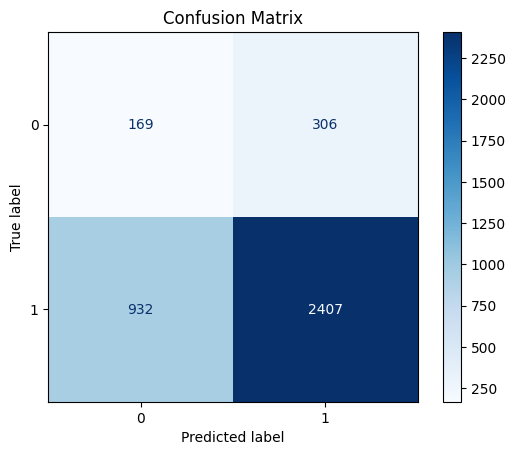

Revenue: $35.49


In [179]:
best_params_logistic = {'penalty': 'l2', 'tol': 0.000275040525644709, 'C': 39.129124480426725} #parameters selected by gridsearch
logistic = LogisticRegression(**best_params_logistic, class_weight="balanced", solver = 'sag', max_iter=10000).fit(X_train_scaled, y_train)

# evaluate on test set
start = time.time()
y_pred_logistic  = logistic.predict(X_test_scaled)
prediction_time_logit = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_logit} seconds")
# assess accuracy of the model
accuracy(y_test, y_pred_logistic)
# show confussion matrix
cm1 = matrix(y_test, y_pred_logistic)
logit_income = round(cost_function(y_test, y_pred_logistic),2)
print(f'Revenue: ${logit_income}')

We can play around with the probabilities to check which one maximizes the revenue:

In [178]:
logit_probs = logistic.predict_proba(X_test_scaled)[:,1]
ranges = np.arange(0.05, 0.95, 0.05)
logit_incomes = {}
for i in ranges:
  logit_predicts = (logit_probs > i).astype(int)
  logit_incomes[i]  = round(cost_function(y_test, logit_predicts), 2)
logit_income = max(logit_incomes.values())
print(f'Revenue: ${logit_income}\nProba: {max(logit_incomes.keys(), key = logit_incomes.get):.2f}')

Revenue: $43.68
Proba: 0.75


Save the model:

In [ ]:
joblib.dump(logistic, '/content/drive/MyDrive/logit.pkl')

['/content/drive/MyDrive/logit.pkl']

#### Ridge Classifier:

Prediction time: 0.02520 seconds
share of 0`s in the dataset:  12.5%

accuracy:  67.3%

              precision    recall  f1-score   support

           0       0.15      0.35      0.21       475
           1       0.89      0.72      0.79      3339

    accuracy                           0.67      3814
   macro avg       0.52      0.53      0.50      3814
weighted avg       0.79      0.67      0.72      3814



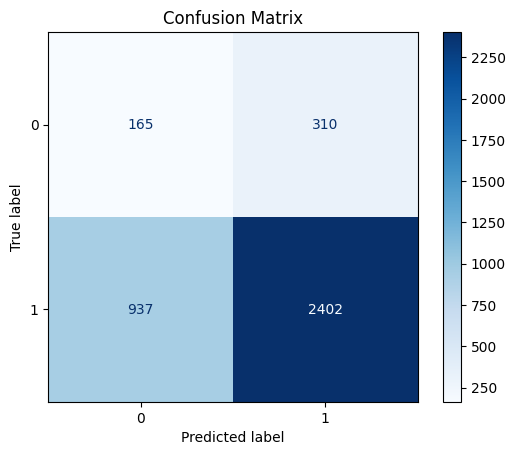

Revenue: $34.86


In [ ]:
best_params_ridge = {'alpha': 9.867013807063731, 'tol': 0.057754922792102724, 'positive': False}

ridge_model = RidgeClassifier(**best_params_ridge, class_weight='balanced', random_state=42).fit(X_train_scaled, y_train)

# evaluate on test set
start = time.time()
y_pred_ridge = ridge_model.predict(X_test_scaled)
prediction_time_ridge = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_ridge:.5f} seconds")

# assess accuracy of the model
accuracy(y_test, y_pred_ridge)
# show confussion matrix
cm1 = matrix(y_test, y_pred_ridge)
ridge_income = round(cost_function(y_test, y_pred_ridge), 2)
print(f'Revenue: ${ridge_income:.2f}')

In [ ]:
joblib.dump(ridge_model, '/content/drive/MyDrive/ridge.pkl')

['/content/drive/MyDrive/ridge.pkl']

#### SGD Classifier:

Prediction time: 0.01404 seconds
share of 0`s in the dataset:  12.5%

accuracy:  87.1%

              precision    recall  f1-score   support

           0       0.18      0.01      0.02       475
           1       0.88      0.99      0.93      3339

    accuracy                           0.87      3814
   macro avg       0.53      0.50      0.48      3814
weighted avg       0.79      0.87      0.82      3814



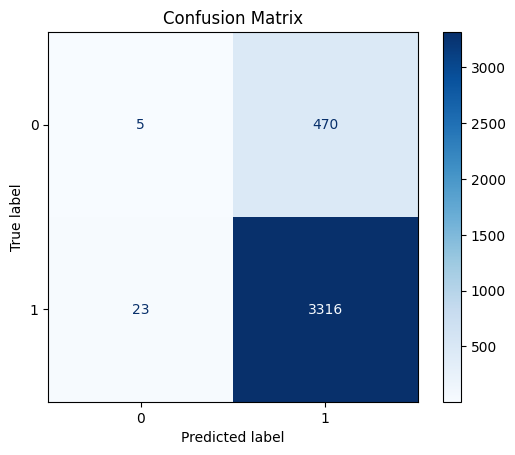

Revenue: $43.08


In [ ]:
best_params_sgd = {'loss': 'squared_hinge',
 'penalty': 'elasticnet',
 'alpha': 33.820968906463726,
 'l1_ratio': 0.3884827302592708,
 'tol': 0.06417175667665795,
 'learning_rate': 'optimal',
 'power_t': 8.608543750732,
 'average': True}  #as selected by optuna

sgd_model = SGDClassifier(**best_params_sgd, class_weight='balanced', random_state=42, n_jobs=-1, max_iter = 100000).fit(X_train_scaled, y_train)

# evaluate on test set
start = time.time()
y_pred_sgd = sgd_model.predict(X_test_scaled)
prediction_time_sgd = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_sgd:.5f} seconds")
# assess accuracy of the model
accuracy(y_test, y_pred_sgd)
# show confussion matrix
cm1 = matrix(y_test, y_pred_sgd)
sgd_income = round(cost_function(y_test, y_pred_sgd), 2)
print(f'Revenue: ${sgd_income}')

In [ ]:
joblib.dump(sgd_model, '/content/drive/MyDrive/sgd.pkl')

['/content/drive/MyDrive/sgd.pkl']

#### Passive Agressive Classifier:

Prediction time: 0.00108 seconds
share of 0`s in the dataset:  12.5%

accuracy:  73.6%

              precision    recall  f1-score   support

           0       0.16      0.26      0.20       475
           1       0.88      0.80      0.84      3339

    accuracy                           0.74      3814
   macro avg       0.52      0.53      0.52      3814
weighted avg       0.79      0.74      0.76      3814



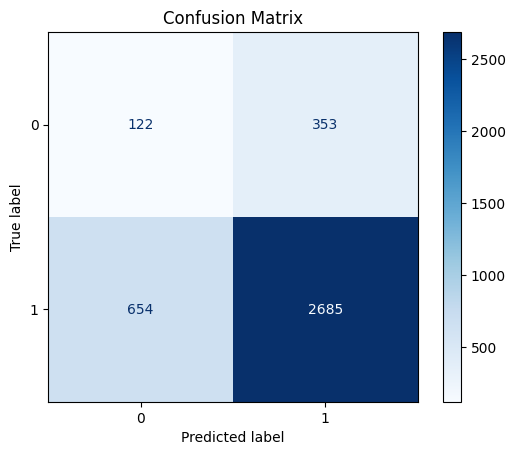

Revenue: $38.19


In [ ]:
best_params_pac = {'loss': 'hinge', 'C': 0.0005527672405032676, 'tol': 0.20677455553584034}

# Train the model
pac_model = PassiveAggressiveClassifier(**best_params_pac, class_weight='balanced', max_iter=100000, random_state=42, n_jobs=-1).fit(X_train_scaled, y_train)
# evaluate on test set
start = time.time()
y_pred_pac = pac_model.predict(X_test_scaled)
prediction_time_pac = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_pac:.5f} seconds")
# assess accuracy of the model
accuracy(y_test, y_pred_pac)
# show confussion matrix
cm1 = matrix(y_test, y_pred_pac)
pac_model_income = round(cost_function(y_test, y_pred_pac), 2)
print(f'Revenue: ${pac_model_income}')

## CUML: Support Vector Machine & Random Forest

#### SVM:

Start with sklearn's SVM:

In [ ]:
%%time
svm = SVC().fit(X_train_scaled, y_train)

# evaluate on test set
y_pred_svm  = svm.predict(X_test_scaled)
# assess accuracy of the model
accuracy(y_test, y_pred_svm)
# show confussion matrix
cm_svm = matrix(y_test, y_pred_svm)

Since CPU computing is cumbersome, we can take advantage of Colab's GPU

In [ ]:
!nvidia-smi

Mon Jun 23 13:02:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   43C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 596 (delta 128), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (596/596), 195.77 KiB | 845.00 KiB/s, done.
Resolving deltas: 100% (302/302), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.13 environment at: /usr
Resolved 173 packages in 11.25s
 Downloaded cuproj-cu12
 Downloaded rmm-cu12
 Downloaded shapely
 Downloaded cudf-cu12
 Downloaded datashader
 Downloaded ucx-py-cu12
 Downloaded libkvikio-cu12
 Downloaded pylibcugraph-cu12
 Downloaded cugraph-cu12
 Downloaded dask
 Downloaded cuspatial-cu12
 Downloaded bokeh
 Downloaded librmm-cu12
 Downloaded cucim-cu12
 Downloaded cuml-cu12
 Downloaded libcuspatial-cu12
 Downloaded pylibcudf-cu12
 Downloaded libraft-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuml-cu12
 Downloaded libcudf-cu12
 Downloaded libc

In [ ]:
from cuml.svm import SVC as cuML_SVC
from cuml.svm import LinearSVC
from cuml.ensemble import RandomForestClassifier as cuRFC

import cudf
import cupy as cp

In [ ]:
X_train_cudf = cudf.DataFrame.from_pandas(X_train)
y_train_cudf = cudf.Series(y_train)

X_test_cudf = cudf.DataFrame.from_pandas(X_test)
y_test_cudf = cudf.Series(y_test)


X_train_cp = cp.asarray(X_train_scaled)
y_train_cp = cp.asarray(y_train)

X_test_cp = cp.asarray(X_test_scaled)
y_test_cp = cp.asarray(y_test)

Prediction time: 0.00599 seconds
share of 0`s in the dataset:  12.5%

accuracy:  87.7%

              precision    recall  f1-score   support

           0       0.67      0.02      0.04       475
           1       0.88      1.00      0.93      3339

    accuracy                           0.88      3814
   macro avg       0.77      0.51      0.49      3814
weighted avg       0.85      0.88      0.82      3814



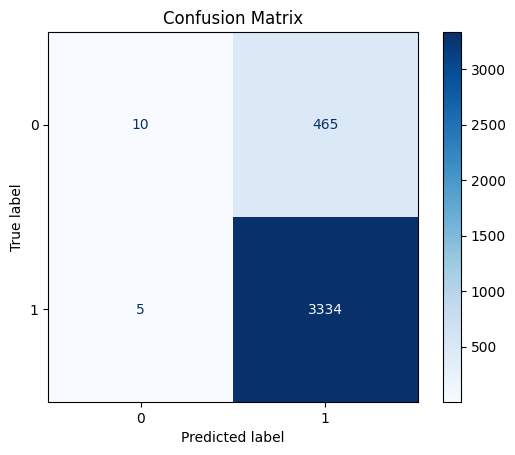

Revenue: $44.22


In [ ]:
params_svm = {'kernel': 'poly',
 'C': 0.0024232210560365475,
 'degree': 2,
 'tol': 0.09513851785455621,
 'gamma': 'auto',
 'coef0': 0.7413456619290114}

# Train the cuML SVC model on the GPU
cu_svm = cuML_SVC(**params_svm, class_weight='balanced', random_state=42).fit(X_train_cp, y_train_cp)

# Make predictions
start = time.time()
y_pred_cu_svm = cu_svm.predict(X_test_cp)
prediction_time_svm = time.time() - start
print(f"Prediction time: {prediction_time_svm:.5f} seconds")
# assess accuracy of the model
accuracy(y_test_cp.get(), y_pred_cu_svm.get())

# Evaluate the model
cu_svm_CM = matrix(y_test_cp.get(), y_pred_cu_svm.get())
print(f'Revenue: ${cost_function(y_test_cp.get(), y_pred_cu_svm.get()):.2f}')

In [ ]:
joblib.dump(cu_svm, '/content/drive/MyDrive/cu_svm.pkl')

['/content/drive/MyDrive/cu_svm.pkl']

Prediction time: 0.00078 seconds
share of 0`s in the dataset:  12.5%

accuracy:  86.4%

              precision    recall  f1-score   support

           0       0.28      0.06      0.10       475
           1       0.88      0.98      0.93      3339

    accuracy                           0.86      3814
   macro avg       0.58      0.52      0.51      3814
weighted avg       0.81      0.86      0.82      3814



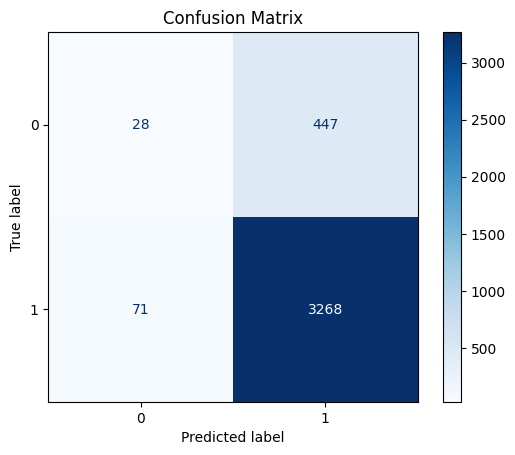

Revenue: $44.40


In [ ]:
# Train the cuML SVC model on the GPU
par = {'penalty': 'l1', 'loss': 'hinge', 'fit_intercept': True, 'C': 0.0035970095564506655, 'tol': 0.09661137611779652}

lsvm = LinearSVC(**par, class_weight='balanced').fit(X_train_cp, y_train_cp)

# Make predictions
start = time.time()
y_pred_lsvm = lsvm.predict(X_test_cp)
prediction_time_lsvm = time.time() - start
print(f"Prediction time: {prediction_time_lsvm:.5f} seconds")

# assess accuracy of the model
accuracy(y_test_cp.get(), y_pred_lsvm.get())

# Evaluate the model
cu_lsvm_CM = matrix(y_test_cp.get(), y_pred_lsvm.get())
print(f'Revenue: ${cost_function(y_test_cp.get(), y_pred_lsvm.get()):.2f}')

In [ ]:
joblib.dump(lsvm, '/content/drive/MyDrive/lsvm.pkl')

['/content/drive/MyDrive/lsvm.pkl']

#### Random Forest:

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Prediction time: 0.06840 seconds
share of 0`s in the dataset:  12.5%

accuracy:  87.6%

              precision    recall  f1-score   support

           0       0.71      0.01      0.02       475
           1       0.88      1.00      0.93      3339

    accuracy                           0.88      3814
   macro avg       0.80      0.50      0.48      3814
weighted avg       0.86      0.88      0.82      3814



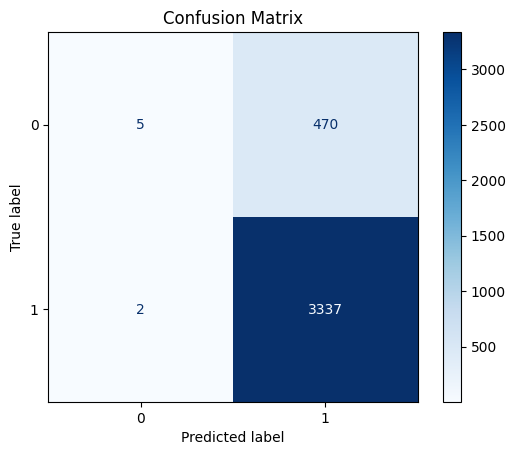

Revenue: $43.71


In [ ]:
params_rfc = {'n_estimators': 255, 'split_criterion': 0, 'max_depth': 30, 'max_features': 'sqrt', 'n_bins': 934}


# Train
rfc_model = cuRFC(**params_rfc, random_state=42).fit(X_train_cudf, y_train_cudf)

# Predict
start = time.time()
y_pred_rfc = rfc_model.predict(X_test_cudf)
prediction_time_rfc = time.time() - start
print(f"Prediction time: {prediction_time_rfc:.5f} seconds")

# Evaluate
accuracy(y_test_cudf.to_numpy(), y_pred_rfc.to_numpy())
cu_rfc_CM = matrix(y_test_cudf.to_numpy(), y_pred_rfc.to_numpy())
print(f'Revenue: ${cost_function(y_test_cudf.to_numpy(), y_pred_rfc.to_numpy()):.2f}')

## Boosting & Bagging

#### AdaBoost:

Prediction time: 0.04570 seconds
share of 0`s in the dataset:  12.5%

accuracy:  87.5%

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       475
           1       0.88      1.00      0.93      3339

    accuracy                           0.88      3814
   macro avg       0.44      0.50      0.47      3814
weighted avg       0.77      0.88      0.82      3814



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


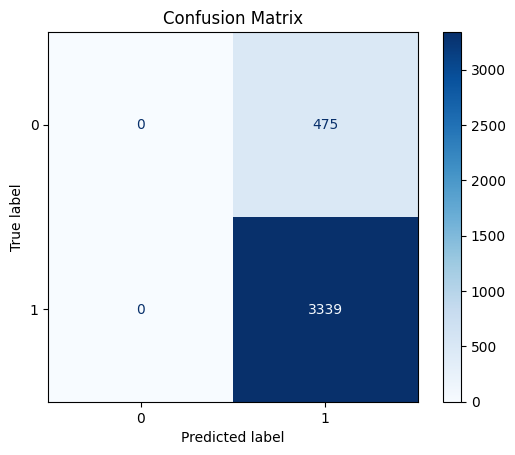

Revenue: $43.17


In [ ]:
adaboost_params = {'n_estimators': 79, 'learning_rate': 0.018733261689340367}
estimator = None
adaboost_model = AdaBoostClassifier(**adaboost_params, estimator = estimator, random_state=0)

# Train
adaboost_model.fit(X_train, y_train)

# Predict
start = time.time()
y_pred_adaboost = adaboost_model.predict(X_test)
prediction_time_adaboost = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_adaboost:.5f} seconds")

# Evaluate
accuracy(y_test, y_pred_adaboost)
adaboost_CM = matrix(y_test, y_pred_adaboost)
adaboost_model_income = round(cost_function(y_test, y_pred_adaboost), 2)
print(f'Revenue: ${adaboost_model_income}')

#### Bagging:

In [ ]:
# Train
bagging_model = BaggingClassifier(estimator=SVC(), n_estimators=100, random_state=0).fit(X_train, y_train)

# Predict
start = time.time()
y_pred_bagging = bagging_model.predict(X_test)
prediction_time_bagging = time.time() - start
print(f"Prediction time: {prediction_time_bagging:.5f} seconds")

# Evaluate
accuracy(y_test, y_pred_bagging)
bagging_CM = matrix(y_test, y_pred_bagging)
print(f'Revenue: ${cost_function(y_test, y_pred_bagging):.2f}')

#### Gradient Boosting:

Prediction time: 0.03448 seconds
share of 0`s in the dataset:  12.5%

accuracy:  85.8%

              precision    recall  f1-score   support

           0       0.19      0.04      0.07       475
           1       0.88      0.97      0.92      3339

    accuracy                           0.86      3814
   macro avg       0.53      0.51      0.50      3814
weighted avg       0.79      0.86      0.82      3814



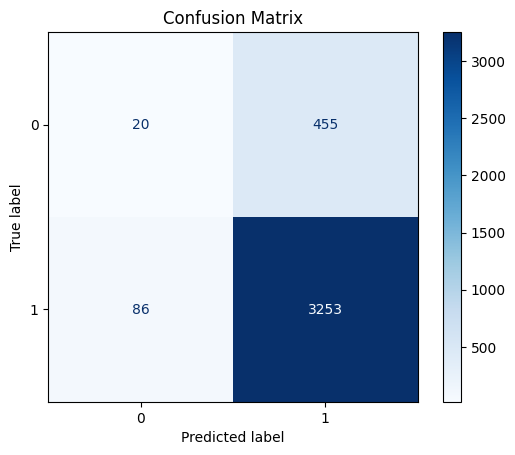

Revenue: $42.99


In [ ]:
# Train
gb_best_params = {'loss': 'exponential', 'learning_rate': 0.45287440634542203, 'n_estimators': 435, 'subsample': 0.7523625470383336, 'criterion': 'friedman_mse', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.0629793529628721, 'max_features': 'sqrt'}
gb = GradientBoostingClassifier(**gb_best_params, random_state=0).fit(X_train, y_train)

# Predict
start = time.time()
y_pred_gb = gb.predict(X_test)
prediction_time_gb = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_gb:.5f} seconds")

# Evaluate
accuracy(y_test, y_pred_gb)
gb_CM = matrix(y_test, y_pred_gb)
gb_income = round(cost_function(y_test, y_pred_gb), 2)
print(f'Revenue: ${gb_income}')

Training of the models in this section is very slow (30+ mins), so even in case of good results, it would be of no use in real-life trading

## LDA & QDA

#### LDA:

Prediction time: 0.02652 seconds
share of 0`s in the dataset:  12.5%

accuracy:  87.5%

              precision    recall  f1-score   support

           0       0.45      0.02      0.04       475
           1       0.88      1.00      0.93      3339

    accuracy                           0.87      3814
   macro avg       0.67      0.51      0.49      3814
weighted avg       0.82      0.87      0.82      3814



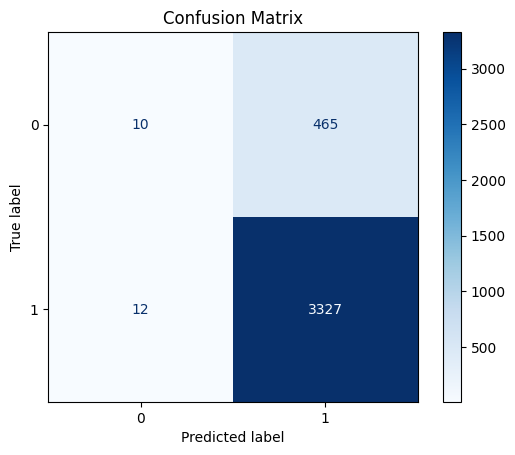

Revenue: $44.01


In [ ]:
lda_best_params = {'solver': 'lsqr', 'tol': 3.618156325933854e-05, 'shrinkage': 0.75}

lda = LinearDiscriminantAnalysis(**lda_best_params).fit(X_train_scaled, y_train)

start = time.time()
y_pred_lda = lda.predict(X_test_scaled)
prediction_time_lda = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_lda:.5f} seconds")
# assess accuracy of the model
accuracy(y_test, y_pred_lda)
# Evaluate the model
lda_CM = matrix(y_test, y_pred_lda)
lda_income = round(cost_function(y_test, y_pred_lda), 2)
print(f'Revenue: ${lda_income}')

In [ ]:
lda_probs = lda.predict_proba(X_test_scaled)[:,1]
ranges = np.arange(0.05, 0.95, 0.05)
lda_incomes = {}
for i in ranges:
  lda_predicts = (lda_probs > i).astype(int)
  lda_incomes[i]  = round(cost_function(y_test, lda_predicts), 2)
lda_income = max(lda_incomes.values())
print(f'Revenue: ${lda_income}\nProba: {max(lda_incomes.keys(), key = lda_incomes.get):.2f}')

Revenue: $44.49
Proba: 0.55


In [ ]:
joblib.dump(lda, '/content/drive/MyDrive/lda.pkl')

['/content/drive/MyDrive/lda.pkl']

#### QDA:

Prediction time: 0.01219 seconds
share of 0`s in the dataset:  12.5%

accuracy:  85.3%

              precision    recall  f1-score   support

           0       0.24      0.08      0.12       475
           1       0.88      0.96      0.92      3339

    accuracy                           0.85      3814
   macro avg       0.56      0.52      0.52      3814
weighted avg       0.80      0.85      0.82      3814



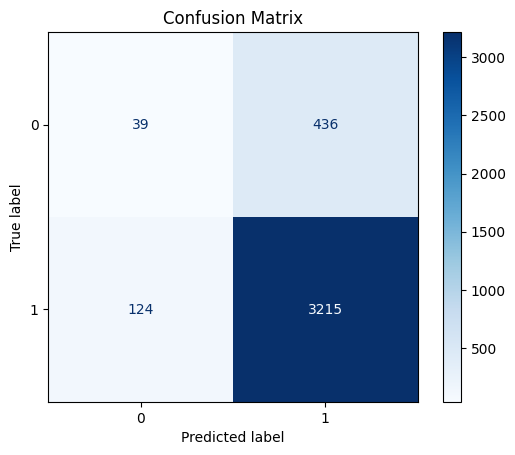

Revenue: $44.13


In [219]:
qda_best_params = {'reg_param': 0.6530087090964536, 'tol': 0.0571014257781193}

qda = QuadraticDiscriminantAnalysis(**qda_best_params).fit(X_train_scaled, y_train)

start = time.time()
y_pred_qda = qda.predict(X_test_scaled)
prediction_time_qda = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_qda:.5f} seconds")
# assess accuracy of the model
accuracy(y_test, y_pred_qda)
# Evaluate the model
qda_CM = matrix(y_test, y_pred_qda)
qda_income = round(cost_function(y_test, y_pred_qda), 2)
print(f'Revenue: ${qda_income}')

In [220]:
qda_probs = qda.predict_proba(X_test_scaled)[:,1]
ranges = np.arange(0.05, 0.95, 0.05)
qda_incomes = {}
for i in ranges:
  qda_predicts = (qda_probs > i).astype(int)
  qda_incomes[i]  = round(cost_function(y_test, qda_predicts), 2)
qda_income = max(qda_incomes.values())
print(f'Revenue: ${qda_income}\nProba: {max(qda_incomes.keys(), key = qda_incomes.get):.2f}')

Revenue: $44.13
Proba: 0.50


In [221]:
joblib.dump(qda, '/content/drive/MyDrive/qda.pkl')

['/content/drive/MyDrive/qda.pkl']

## XGBoost

download the package:

In [ ]:
!pip install xgboost
from xgboost import XGBClassifier

Prediction time: 0.03262 seconds
share of 0`s in the dataset:  12.5%

accuracy:  86.4%

              precision    recall  f1-score   support

           0       0.20      0.03      0.05       475
           1       0.88      0.98      0.93      3339

    accuracy                           0.86      3814
   macro avg       0.54      0.51      0.49      3814
weighted avg       0.79      0.86      0.82      3814



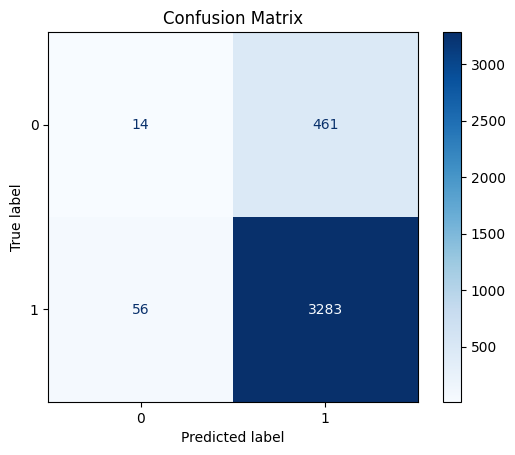

Revenue: $43.17


In [ ]:
best_params = {'objective': 'binary:hinge', 'eval_metric': 'error', 'n_estimators': 906, 'learning_rate': 0.23405284354449818, 'max_depth': 4, 'max_leaves': 6, 'min_child_weight': 3, 'subsample': 0.9534073606686936, 'colsample_bytree': 0.7202384490985456, 'gamma': 3.5385152020213733, 'reg_alpha': 0.7064225792629669, 'reg_lambda': 0.0014031107520006273}


xgb_model = XGBClassifier(n_jobs=-1, **best_params).fit(X_train, y_train)

# evaluate on test set
start = time.time()
y_pred_xgb  = xgb_model.predict(X_test)
prediction_time_xgb = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_xgb:.5f} seconds")
# assess accuracy of the model
accuracy(y_test, y_pred_xgb)
# show confussion matrix
XGB_cm1 = matrix(y_test, y_pred_xgb)
xgb_income = round(cost_function(y_test, y_pred_xgb), 2)
print(f'Revenue: ${xgb_income}')

In [ ]:
joblib.dump(xgb_model, '/content/drive/MyDrive/xgb_model.pkl')

['/content/drive/MyDrive/xgb_model.pkl']

## Deep Learning

#### Sklearn's neural network:

Prediction time: 0.19323 seconds
share of 0`s in the dataset:  12.5%

accuracy:  87.5%

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       475
           1       0.88      1.00      0.93      3339

    accuracy                           0.88      3814
   macro avg       0.44      0.50      0.47      3814
weighted avg       0.77      0.88      0.82      3814



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


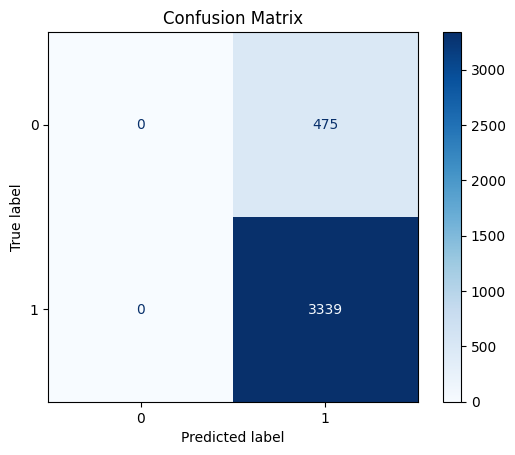

Revenue: $43.17


In [ ]:
mlp_best_params = {'hidden_layer_sizes': tuple(200 for i in range(10)),
'activation': 'tanh',
'alpha': 0.07470305318252356,
'learning_rate': 'invscaling',
'learning_rate_init': 0.0019635502076883293,
'tol': 0.013494442669255386}

# Train
mlp = MLPClassifier(**mlp_best_params).fit(X_train_scaled, y_train)

# Predict
start = time.time()
y_pred_mlp = mlp.predict(X_test_scaled)
prediction_time_mlp = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_mlp:.5f} seconds")

# Evaluate
accuracy(y_test, y_pred_mlp)
mlp_CM = matrix(y_test, y_pred_mlp)
mlp_income = round(cost_function(y_test, y_pred_mlp), 2)
print(f'Revenue: ${mlp_income}')

#### Tensorflow:

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Prediction time: 0.38920 seconds
share of 0`s in the dataset:  12.5%

accuracy:  77.6%

              precision    recall  f1-score   support

           0       0.15      0.17      0.16       475
           1       0.88      0.86      0.87      3339

    accuracy                           0.78      3814
   macro avg       0.51      0.51      0.51      3814
weighted avg       0.79      0.78      0.78      3814



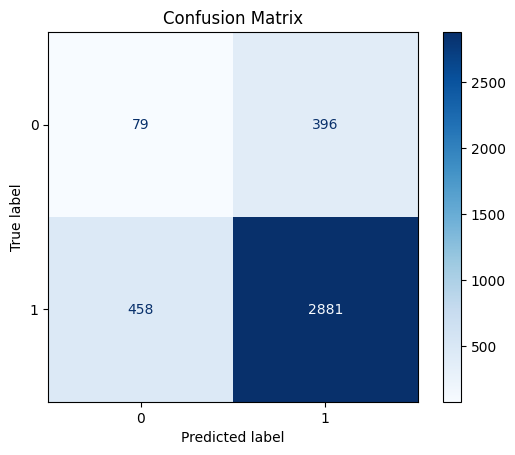

Revenue: $38.91


In [ ]:
nn_model = Sequential()

nn_model.add(Dense(units=10,                  # number of units the layer has
                activation='sigmoid',        # activation function
                 ))
nn_model.add(Dense(units=50,
                activation='relu',
                 ))
nn_model.add(Dense(units=100,
                activation='tanh',
                 ))
nn_model.add(Dense(units=100,
                activation='relu',
                 ))
nn_model.add(Dense(units=100,
                activation='sigmoid',
                 ))
nn_model.add(Dense(units=100,
                activation='relu',
                 ))
nn_model.add(Dense(units=100,
                activation='tanh',
                 ))
nn_model.add(Dense(units=100,
                activation='relu',
                 ))
nn_model.add(Dense(units=50,
                activation='sigmoid',
                 ))
nn_model.add(Dense(units=10,
                activation='relu',
                 ))


nn_model.add(Dense(units=1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train
history = nn_model.fit(X_train_scaled, y_train,
                    epochs=1000,
                    batch_size=400,
                    verbose=0,
                   )

# Predict
start = time.time()
y_pred_nn_proba = nn_model.predict(X_test_scaled)
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)
prediction_time_nn = round(time.time() - start, 5)
print(f"Prediction time: {prediction_time_nn:.5f} seconds")

# Evaluate
accuracy(y_test, y_pred_nn)
nn_CM = matrix(y_test, y_pred_nn)
nn_income = round(cost_function(y_test, y_pred_nn), 2)
print(f'Revenue: ${nn_income}')

In [ ]:
nn_probs = nn_model.predict(X_test_scaled)
ranges = np.arange(0.05, 0.95, 0.05)
nn_incomes = {}
for i in ranges:
  nn_predicts = (nn_probs > i).astype(int)
  nn_incomes[i]  = round(cost_function(y_test, nn_predicts), 2)
nn_income = max(nn_incomes.values())
print(f'Revenue: ${nn_income}\nProba: {max(nn_incomes.keys(), key = nn_incomes.get):.2f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Revenue: $41.07
Proba: 0.05


# 3. Hyperparameter tuning

The biggest challenge is to pick the right set of parameters as well as the right accuracy metric. We really care about false positives, since we want to minimize our trading losses. So to optimize the loss function, we use values derived in the first part: for each successful trade we earn on average ~ \$0.03, while each unsuccessul trade costs us \$0.12

In [ ]:
def cost_function(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 0.03*tp-0.12*fp

In [ ]:
def objective_logistic(trial):
    # Define hyperparameters to tune

    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1','l2']),
        'tol': trial.suggest_float("tol", 1e-5, 1e-1, log = True),
        'C': trial.suggest_float("C", 1e-3, 100),
    }

    # Create the model with suggested hyperparameters
    model = LogisticRegression(**params, class_weight='balanced', solver = "saga", max_iter = 10000, n_jobs = -1, random_state=42)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    metric_value = cost_function(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_logistic = optuna.create_study(direction="maximize")
study_logistic.optimize(objective_logistic, n_trials=100, show_progress_bar=True)

study_logistic.best_params

In [ ]:
def objective_ridge(trial):
    # Define hyperparameters to tune

    params = {
        'alpha': trial.suggest_float("alpha", 0.01, 100),
        'tol': trial.suggest_float("tol", 1e-4, 1e-1),
        'positive': trial.suggest_categorical('positive', [True, False])
      }

    # Create the XGBoost model with suggested hyperparameters
    model = RidgeClassifier(**params, class_weight='balanced', random_state=42)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    metric_value = cost_function(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_ridge = optuna.create_study(direction="maximize")
study_ridge.optimize(objective_ridge, n_trials=250, show_progress_bar=True)

study_ridge.best_params

In [ ]:
def objective_sgd(trial):
    # Define hyperparameters to tune

    params = {
        'solver': trial.suggest_categorical("solver", ["hinge", "log_loss", "squared_hinge", "modified_huber", "perceptron", 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']),
        'penalty': trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet", None]),
        'alpha': trial.suggest_float("alpha", 1e-5, 100),
        'l1_ratio': trial.suggest_float("l1_ratio", 0.0, 1.0),
        'tol': trial.suggest_float("tol", 1e-5, 1e-1),
        'learning_rate': trial.suggest_categorical("learning_rate", ["constant", "optimal", "invscaling", "adaptive"]),
        'power_t': trial.suggest_float("power_t", -10, 10),
        'average' : trial.suggest_categorical("average", [False, True])

    }

    params['eta0'] = trial.suggest_float("eta0", 0, 10) if params['learning_rate'] in ("constant", "invscaling", "adaptive") else 0.0
    params['epsilon'] = trial.suggest_float("epsilon", 0, 10) if params['loss'] in ('huber', 'epsilon_insensitive', 'squared_epsilon_insensitive') else 0.0

    # Create the model with suggested hyperparameters
    model = SGDClassifier(**params, class_weight='balanced', max_iter = 10000, random_state=42, n_jobs=-1)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    metric_value = cost_function(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_sgd = optuna.create_study(direction="maximize")
study_sgd.optimize(objective_sgd, n_trials=1000, show_progress_bar=True)

study_sgd.best_params

In [ ]:
def objective_pac(trial):
    # Define hyperparameters to tune

    params = {
        'loss': trial.suggest_categorical("loss", ["hinge", "squared_hinge"]),
        'C': trial.suggest_float("C", 1e-5, 10),
        'tol': trial.suggest_float("tol", 1e-5, 1)
    }

    # Create the model with suggested hyperparameters
    model = PassiveAggressiveClassifier(**params, class_weight='balanced', max_iter=10000, random_state=42, n_jobs=-1)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    metric_value = cost_function(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_pac = optuna.create_study(direction="maximize")
study_pac.optimize(objective_pac, n_trials=1000, show_progress_bar=True)

study_pac.best_params

In [ ]:
def objective_SVM(trial):

    # Define hyperparameters to tune
    params = {
        'kernel': trial.suggest_categorical("kernel", ['poly', 'rbf', 'sigmoid']),
        'C': trial.suggest_float("C", 1e-5, 10),
        'degree': trial.suggest_int("degree", 1, 5),
        'tol': trial.suggest_float("tol", 1e-5, 1e-1),
        'gamma': trial.suggest_categorical("gamma", ['scale', 'auto']),
        'coef0': trial.suggest_float("coef0", -5, 5)
    }

    # Create the model with suggested hyperparameters
    model = cuML_SVC(**params, class_weight='balanced', random_state=42)

    # Train the model
    model.fit(X_train_cp, y_train_cp)

    # Predict
    y_pred = model.predict(X_test_cp)
    metric_value = cost_function(y_test_cp.get(), y_pred.get())

    return metric_value

# Create and run the Optuna study
study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(objective_SVM, n_trials=1000, show_progress_bar=True)

study_svm.best_params

In [ ]:
def objective_lSVM(trial):
    params = {
        'penalty': trial.suggest_categorical("penalty", ['l1', 'l2']),
        'loss': trial.suggest_categorical("loss", ['squared_hinge', 'hinge']),
        'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
        'C': trial.suggest_float("C", 1e-5, 10.0, log=True),
        'tol': trial.suggest_float("tol", 1e-6, 1e-1)
    }

    model = LinearSVC(**params, class_weight='balanced', max_iter = 10000)
    model.fit(X_train_cp, y_train_cp)

    y_pred = model.predict(X_test_cp)
    score = cost_function(y_test_cp.get(), y_pred.get())

    return score

# Run Optuna study
study_lsvm = optuna.create_study(direction="maximize")
study_lsvm.optimize(objective_lSVM, n_trials=1000, show_progress_bar=True)

print(study_lsvm.best_params)

In [ ]:
def objective_rfc(trial):
    params = {
        "n_estimators":          trial.suggest_int(   "n_estimators",    50,   5000),
        "split_criterion":       trial.suggest_categorical(
                                    "split_criterion", [0, 1]  # 0='gini', 1='entropy'
                                ),
        "max_depth":             trial.suggest_int(   "max_depth",      5,   50),
        "max_features":          trial.suggest_categorical(
                                    "max_features",  ["sqrt", "log2"]
                                ),
        "n_bins":                trial.suggest_int(   "n_bins",        128, 1024)
    }

    model = cuRFC(**params, random_state=42, n_streams=1)
    model.fit(X_train_cudf, y_train_cudf)

    y_pred = model.predict(X_test_cudf)
    score = cost_function(y_test_cudf.to_numpy(), y_pred.to_numpy())


    return score

# Run Optuna study
study_rfc = optuna.create_study(direction="maximize")
study_rfc.optimize(objective_rfc, n_trials=1000, show_progress_bar=True)

print(study_rfc.best_params)

In [ ]:
def objective_adaboost(trial):
    # Define hyperparameters to tune

    params = {
        'estimator':             trial.suggest_categorical("estimator", [None, 'DecisionTreeClassifier', 'ExtraTreeClassifier']),
        'n_estimators':          trial.suggest_int("n_estimators", 50, 250),
        "learning_rate":         trial.suggest_float("learning_rate", 0.01, 5, log = True)
    }

    if params['estimator'] == 'DecisionTreeClassifier':
          weak_params = {'criterion':             trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])}
          max_depth_t = trial.suggest_categorical("max_depth_t", ['None', 'NotNone'])
          weak_params['max_depth'] = None if max_depth_t == 'None' else trial.suggest_int("max_depth", 50, 250)
          params['estimator'] = DecisionTreeClassifier(**weak_params, random_state = 42, class_weight="balanced")

    if params['estimator'] == 'ExtraTreeClassifier':
          weak_params = {
            'criterion':             trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss']),
            'max_features':          trial.suggest_categorical("max_features", [None, 'sqrt', 'log2'])
            }
          max_depth_t = trial.suggest_categorical("max_depth_t", ['None', 'NotNone'])
          weak_params['max_depth'] = None if max_depth_t == 'None' else trial.suggest_int("max_depth", 50, 250)
          params['estimator'] = ExtraTreeClassifier(**weak_params, random_state = 42, class_weight="balanced")

    # Create the model with suggested hyperparameters
    model = AdaBoostClassifier(**params, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    metric_value = cost_function(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_adaboost = optuna.create_study(direction="maximize")
study_adaboost.optimize(objective_adaboost, n_trials=150, show_progress_bar=True)

study_adaboost.best_params

In [ ]:
def objective_gb(trial):
    # 1) sample hyperparameters
    params = {
        "loss":                    trial.suggest_categorical("loss", ["log_loss", "exponential"]),
        "learning_rate":           trial.suggest_float("learning_rate", 1e-3, 1.0, log = True),
        "n_estimators":            trial.suggest_int("n_estimators", 50, 500),
        "subsample":               trial.suggest_float("subsample", 0.5, 1.0),
        "criterion":               trial.suggest_categorical("criterion", ["friedman_mse", "squared_error"]),
        "min_samples_split":       trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf":        trial.suggest_int("min_samples_leaf", 1, 20),
        "max_depth":               trial.suggest_int("max_depth", 1, 10),
        "min_impurity_decrease":   trial.suggest_float("min_impurity_decrease", 0.0, 1e-1),
        "max_features":            trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
        "random_state":            42
    }

    clf = GradientBoostingClassifier(**params)

    # Train the model
    clf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test)
    metric_value = cost_function(y_test, y_pred)

    return metric_value

# 3) run Optuna
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(objective_gb, n_trials=100, show_progress_bar=True)
study_gb.best_params

In [ ]:
def objective_lda(trial):

    solver = trial.suggest_categorical("solver", ["svd", "lsqr", "eigen"])
    tol = trial.suggest_float("tol", 1e-6, 1e-1, log = True)
    if solver != "svd":
      shrinkage = trial.suggest_categorical("shrinkage", [None, "auto", 0.1, 0.25, 0.5, 0.75, 0.99])
      # build the model
      clf = LinearDiscriminantAnalysis(
          solver=solver,
          shrinkage=shrinkage,
          tol=tol
      )
    else:
      clf = LinearDiscriminantAnalysis(
          solver=solver,
          tol=tol
      )


    # Train the model
    try:
      clf.fit(X_train_scaled, y_train)

      # Evaluate the model
      y_pred = clf.predict(X_test_scaled)
      metric_value = cost_function(y_test, y_pred)
    except: metric_value = 0
    return metric_value


study_lda = optuna.create_study(direction="maximize")
study_lda.optimize(objective_lda, n_trials=1000, show_progress_bar=True)
study_lda.best_params

In [ ]:
def objective_qda(trial):
    # 1) Suggest QDA hyperparameters
    reg_param = trial.suggest_float("reg_param", 0.0, 1)
    tol        = trial.suggest_float("tol", 1e-6, 1e-1, log=True)

    # 2) Build the model
    clf = QuadraticDiscriminantAnalysis(
        reg_param=reg_param,
        tol=tol
    )

    clf.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test_scaled)
    metric_value = cost_function(y_test, y_pred)

    return metric_value

# 4) Run the study
study_qda = optuna.create_study(direction="maximize")
study_qda.optimize(objective_qda, n_trials=250, show_progress_bar=True)
study_qda.best_params

In [ ]:
def objective_xgb(trial):
    # Define hyperparameters to tune
    params = {
        "objective": trial.suggest_categorical("objective", ["binary:hinge", "binary:logistic"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["error", "auc"]),
        "random_state": 42,
        "n_jobs": -1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        'max_leaves': trial.suggest_int("max_leaves", 0, 10),
        'min_child_weight': trial.suggest_int("min_child_weight", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
    }

    # Create the XGBoost model with suggested hyperparameters
    model = XGBClassifier(**params)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    metric_value = cost_function(y_test, y_pred)

    return metric_value

# Create and run the Optuna study
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=1000, show_progress_bar=True)

study_xgb.best_params

In [ ]:
def objective_mlp(trial):

    n_layers = 11
    hidden_layer_sizes = tuple(
        trial.suggest_int(f"n_units_l{i}", 32, 256)
        for i in range(n_layers - 2)
    )
    activation          = trial.suggest_categorical("activation", ["identity","logistic","tanh","relu"])
    alpha               = trial.suggest_float("alpha", 1e-6, 1e-1)
    learning_rate       = trial.suggest_categorical("learning_rate", ["constant","invscaling","adaptive"])
    learning_rate_init  = trial.suggest_float("learning_rate_init", 1e-5, 1e-1)
    tol                 = trial.suggest_float("tol", 1e-5, 1e-1)


    model = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            alpha=alpha,
            learning_rate=learning_rate,
            learning_rate_init=learning_rate_init,
            tol=tol,
            max_iter= 10000,
            random_state=42)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    metric_value = cost_function(y_test, y_pred)

    return metric_value

# 4) Run the study
study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(objective_mlp, n_trials=100, show_progress_bar=True)
study_mlp.best_params

# 4. Backtesting

In [222]:
income = {"Ideal": ideal_income, "Naive": naive_income, "Logit": logit_income, "Ridge": ridge_income, "SGD": sgd_income, "PAC": pac_model_income,
          "SVM (A100)": 44.22, "linear SVM (A100)": 44.4, "Random Forest (A100)": 43.71,
          "AdaBoost": adaboost_model_income, "GradientBoosting": gb_income,
          "LDA": lda_income, "QDA": qda_income,
          "XGBoost": xgb_income, "sklearn NN": mlp_income, "tensorflow NN": nn_income}
performance = {"Logit": prediction_time_logit, "Ridge": prediction_time_ridge, "SGD": prediction_time_sgd, "PAC": prediction_time_pac,
                "SVM (A100)": 0.00599, "linear SVM (A100)": 0.00078 , "Random Forest (A100)": 0.06840,
                "AdaBoost": prediction_time_adaboost, "GradientBoosting": prediction_time_gb,
                "LDA": prediction_time_lda, "QDA": prediction_time_qda,
                "XGBoost": prediction_time_xgb, "sklearn NN": prediction_time_mlp, "tensorflow NN": prediction_time_nn}

pd.DataFrame(data = [income, performance], index = ["income", "performance"])

,Ideal,Naive,Logit,Ridge,SGD,PAC,SVM (A100),linear SVM (A100),Random Forest (A100),AdaBoost,GradientBoosting,LDA,QDA,XGBoost,sklearn NN,tensorflow NN
income,100.17,43.17,35.4900,34.8600,43.08000,38.19000,44.22000,44.40000,43.7100,43.1700,42.99000,44.49000,44.13000,43.17000,43.17000,41.0700
performance,NaN,NaN,0.0015,0.0252,0.01404,0.00108,0.00599,0.00078,0.0684,0.0457,0.03448,0.02652,0.01219,0.03262,0.19323,0.3892


In this section we want to calculate our PnL using different models. Profit-wise performance of all the models is pretty much comparable, so we pick QDA, as it offers a nice balance between speed and precision. We compare it with the naive approach to deduct how efficient ML would be in this setup, since so far models beat the naive approach only marginally

Upload the models:

In [175]:
scaler = joblib.load('/content/drive/MyDrive/scaler.pkl')

qda = joblib.load('/content/drive/MyDrive/qda.pkl')
naive_model = joblib.load('/content/drive/MyDrive/naive_model.pkl')

df_n = pl.read_parquet('/content/drive/MyDrive/df_n_v2.parquet')
arbitrage_model = pl.read_parquet('/content/drive/MyDrive/arbitrage_modelv2.parquet')
arbitrage_model = arbitrage_model.to_pandas()
arbitrage_model.ts = pd.to_numeric(arbitrage_model["ts"]).astype('Int64')


Support functions:

In [313]:
trading_hours = 12
HTX_execution_time = 500  #ms to execute a trade on HTX
Bybit_execution_time = 500  #ms to execute a trade on Bybit
capital = 10000
investment = 250 #usdt per single arbitrage operation
threshold = 10 #minimum arbitrage value


# Define the start timestamp (replace with your desired start time)
start_timestamp_ms = 1746584715064  #2025-04-17

In [314]:
total_expected_profit, total_realized_profit, total_missed_opportunity = cc.backtesing(trained_model = qda,
                                                                                      scaler = scaler,
                                                                                      arbitrage_model = arbitrage_model,
                                                                                      df_n = df_n,
                                                                                      trading_hours = trading_hours,
                                                                                      HTX_execution_time = HTX_execution_time,
                                                                                      Bybit_execution_time = Bybit_execution_time,
                                                                                      capital = capital,
                                                                                      investment = investment,
                                                                                      threshold = threshold,
                                                                                      start_timestamp_ms = start_timestamp_ms)

100%|██████████| 2907/2907 [00:14<00:00, 201.82it/s]
2025-06-26 18:32:14,563 - INFO - Cycle ended. Results:
2025-06-26 18:32:14,563 - INFO - total number of trades: 1305
2025-06-26 18:32:14,564 - INFO - total expected profit, $:  107.41
2025-06-26 18:32:14,564 - INFO - total realized profit, $:  32.38
2025-06-26 18:32:14,565 - INFO - total missed opportunity, $:  2.05


In [315]:
total_expected_profit_naive, total_realized_profit_naive, total_missed_opportunity_naive = cc.backtesing(trained_model = naive_model,
                                                                                                      scaler = scaler,
                                                                                                      arbitrage_model = arbitrage_model,
                                                                                                      df_n = df_n,
                                                                                                      trading_hours = trading_hours,
                                                                                                      HTX_execution_time = HTX_execution_time,
                                                                                                      Bybit_execution_time = Bybit_execution_time,
                                                                                                      capital = capital,
                                                                                                      investment = investment,
                                                                                                      threshold = threshold,
                                                                                                      start_timestamp_ms = start_timestamp_ms)

100%|██████████| 2907/2907 [00:14<00:00, 206.80it/s]
2025-06-26 18:32:32,797 - INFO - Cycle ended. Results:
2025-06-26 18:32:32,797 - INFO - total number of trades: 1320
2025-06-26 18:32:32,797 - INFO - total expected profit, $:  108.88
2025-06-26 18:32:32,798 - INFO - total realized profit, $:  37.72
2025-06-26 18:32:32,799 - INFO - total missed opportunity, $:  0.00
